In [206]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
mat = scipy.io.loadmat('files_tut4/feat_train_vow.mat')
    
x_vow = mat['x_vow']
x_vow = x_vow[0]

mat = scipy.io.loadmat('files_tut4/feat_train_cons.mat')
x_cons = mat['x_cons'][0]

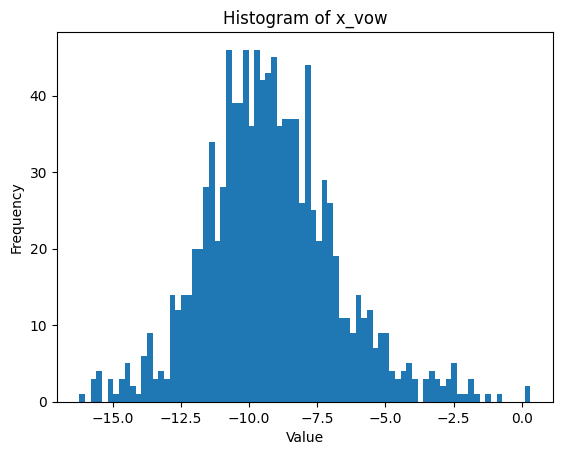

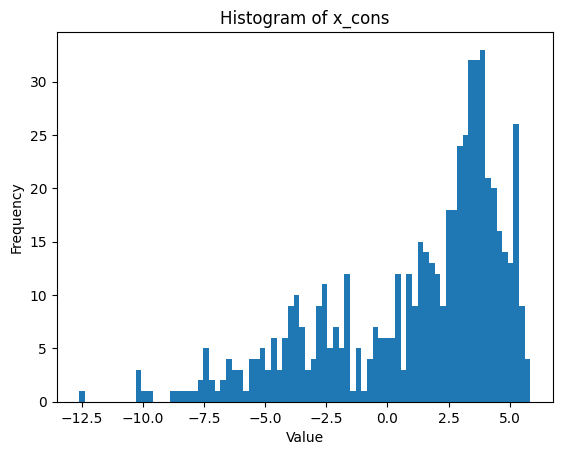

In [208]:
plt.hist(x_vow, bins=80)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of x_vow')
plt.show()

plt.hist(x_cons, bins=80)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of x_cons')
plt.show()

In [209]:

hist_vow, bin_edges_vow = np.histogram(x_vow, bins=80)
bin_centers_vow = (bin_edges_vow[:-1] + bin_edges_vow[1:]) / 2
# print(bin_centers)
# print(hist)

hist_cons, bin_edges_cons = np.histogram(x_cons, bins=80)
bin_centers_cons = (bin_edges_cons[:-1] + bin_edges_cons[1:]) / 2

0.9999999999999999


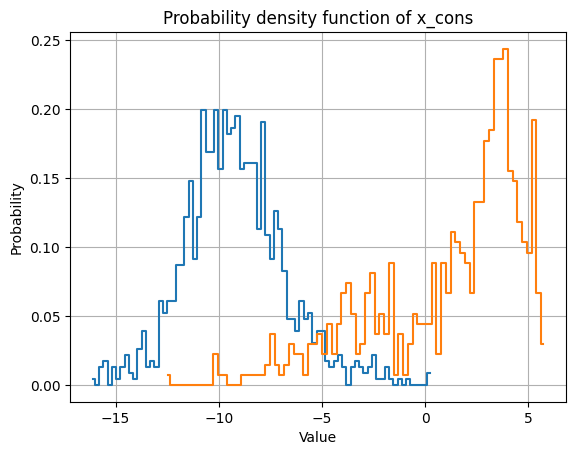

1.0


In [396]:
probabilities = hist_vow / np.sum(hist_vow)
probabilities = probabilities / (bin_centers_vow[1] - bin_centers_vow[0])

plt.step(bin_centers_vow, probabilities, where='mid')
plt.xlabel('Value')
plt.ylabel('Probability')
plt.title('Probability density function of x_vow')
# plt.show()

print(np.sum(probabilities * (bin_centers_vow[1] - bin_centers_vow[0])))

probabilities = hist_cons / np.sum(hist_cons)
probabilities = probabilities / (bin_centers_cons[1] - bin_centers_cons[0])

plt.step(bin_centers_cons, probabilities, where='mid')
plt.xlabel('Value')
plt.ylabel('Probability')
plt.title('Probability density function of x_cons')
plt.grid()
plt.show()

print(np.sum(probabilities * (bin_centers_cons[1] - bin_centers_cons[0])))


In [211]:
def pdf_hist(x, y_hist, x_hist):
    # y_hist is absolute frequency for each bin
    # x_hist is the bin centers
    probabilities = y_hist / np.sum(y_hist)
    probabilities = probabilities / (x_hist[1] - x_hist[0])

    # Finding nearest center for x
    idx = np.abs(x_hist - x).argmin()
    return probabilities[idx]

In [212]:
print(pdf_hist(0.5, hist_vow, bin_centers_vow))
print(pdf_hist(0.5, hist_cons, bin_centers_cons))

0.00868743488946114
0.08868153299332507


# GMMs

In [213]:
from scipy.stats import norm

In [554]:
def pdf_gmm(x, mu, sigma, g):
    return g * norm.pdf(x, mu,sigma)

# print(pdf_gmm(0, 0, 1, 1))

# test_values = np.linspace(-5, 5, num=51)
# probs = pdf_gmm(test_values, 0, 1, 1)
# plt.plot(test_values, probs)

# print(np.sum(probs) * (test_values[1] - test_values[0]))


In [556]:

def calculate_affiliations(x, mu_old, sigma_old, g_old):
    # return matrix k x N
    gama = np.zeros(shape=(4, len(x))) # gama[k, i] is the probability that x_i belongs to the k-th gaussian
    probs = np.zeros(shape=(4, len(x)))
    for k in range(4):
        probs[k] = pdf_gmm(x, mu_old[k], sigma_old[k], g_old[k])

    for i in range(len(x)):
        gama[:, i] = probs[:, i] / np.sum(probs[:, i])
    
    return gama

In [569]:
def gmm_update(x, mu_old, sigma_old, g_old):
    gama = calculate_affiliations(x, mu_old, sigma_old, g_old)

    x_matrix = np.tile(x, (4, 1))
    mu = np.zeros(4)
    sigma = np.zeros(4)
    g = np.zeros(4)

    # for k in range(4):
    #     mu[k] = np.sum(gama[k] * x) / np.sum(gama[k])
    #     sigma[k] = np.sqrt(np.sum(gama[k] * (x - mu_old[k]) * (x - mu_old[k])) / np.sum(gama[k]))
    #     g[k] = np.sum(gama[k]) / len(x)

    mu = np.sum(gama * x_matrix, axis=1) / np.sum(gama, axis=1)

    normalized_x = x_matrix - mu_old[:, np.newaxis]
    normalized_x = normalized_x * normalized_x
    sigma = np.sqrt(np.sum(gama * normalized_x, axis=1) / np.sum(gama, axis=1))
    # sigma = sigma*sigma

    g = np.sum(gama, axis=1) / len(x)

    return (mu, sigma, g)


In [570]:
mat = scipy.io.loadmat('files_tut4/gmm_init_vow.mat')
g_vow_init = mat['g_vow']
g_vow_init = g_vow_init.T[0]
print(g_vow_init)

mu_vow_init = mat['mu_vow']
mu_vow_init = mu_vow_init.T[0]
print(mu_vow_init)

sigma_vow_init = mat['sigma_vow']
sigma_vow_init = np.sqrt(sigma_vow_init.T[0])
print(sigma_vow_init)

mat = scipy.io.loadmat('files_tut4/gmm_init_cons.mat')
g_cons_init = mat['g_cons']
g_cons_init = g_cons_init.T[0]
print(g_cons_init)

mu_cons_init = mat['mu_cons']
mu_cons_init = mu_cons_init.T[0]
print(mu_cons_init)

sigma_cons_init = mat['sigma_cons']
sigma_cons_init = np.sqrt(sigma_cons_init.T[0])
print(sigma_cons_init)

[0.10233393 0.40305206 0.30520646 0.18940754]
[ -4.57225734  -9.93708859  -7.77997827 -12.39607319]
[1.47238721 0.64609928 0.69873197 1.14173768]
[0.17887564 0.26235094 0.08517888 0.47359455]
[-2.77647132  1.3605013  -6.71691358  4.04675263]
[1.04714493 0.95328663 1.71426188 0.7938516 ]


In [571]:
number_of_iterations = 10

g_vow = np.zeros(shape=(1 + number_of_iterations, len(g_vow_init)))
g_vow[0] = g_vow_init.copy()
# print(g_vow)

mu_vow = np.zeros(shape=(1 + number_of_iterations, len(mu_vow_init)))
mu_vow[0] = mu_vow_init.copy()
# print(mu_vow)

sigma_vow = np.zeros(shape=(1 + number_of_iterations, len(sigma_vow_init)))
sigma_vow[0] = sigma_vow_init.copy()
# print(sigma_vow)

g_cons = np.zeros(shape=(1 + number_of_iterations, len(g_cons_init)))
g_cons[0] = g_cons_init.copy()
# print(g_cons)

mu_cons = np.zeros(shape=(1 + number_of_iterations, len(mu_cons_init)))
mu_cons[0] = mu_cons_init.copy()
# print(mu_cons)

sigma_cons = np.zeros(shape=(1 + number_of_iterations, len(sigma_cons_init)))
sigma_cons[0] = sigma_cons_init.copy()
# print(sigma_cons)

p = 9

In [598]:

def plot_full_gaussian(mu, sigma, g, ax):
    x = np.linspace(mu - 4*sigma, mu+4*sigma, num=1000)
    y = np.zeros(len(x))
    y = g * norm.pdf(x, mu, sigma)
    
    ax.plot(x, y)
    # for i in range(4):
    #     print("sum", i, np.trapz(y[:, i], x[:, i]))
    # print(g)

def plot_gaussian_sum(mu, sigma, g, title, ax):
    x = np.linspace(-20, 5, num=1000)
    y = np.zeros(len(x))
    for i in range(len(mu)):
        y += g[i] * norm.pdf(x, mu[i], sigma[i])
    ax.set_title(title)
    ax.plot(x, y)

    print("Integral do plot do gaussiano", np.trapz(y, x))

Integral do plot do gaussiano 0.9999999997550952
Integral do plot do gaussiano 0.9999999986655703
Integral do plot do gaussiano 0.9999999958283274
Integral do plot do gaussiano 0.9999999902842588
Integral do plot do gaussiano 0.9999999811841638
Integral do plot do gaussiano 0.9999999678517432
Integral do plot do gaussiano 0.9999999498084198
Integral do plot do gaussiano 0.9999999267752141
Integral do plot do gaussiano 0.9999998986599825
Integral do plot do gaussiano 0.9999998655357204


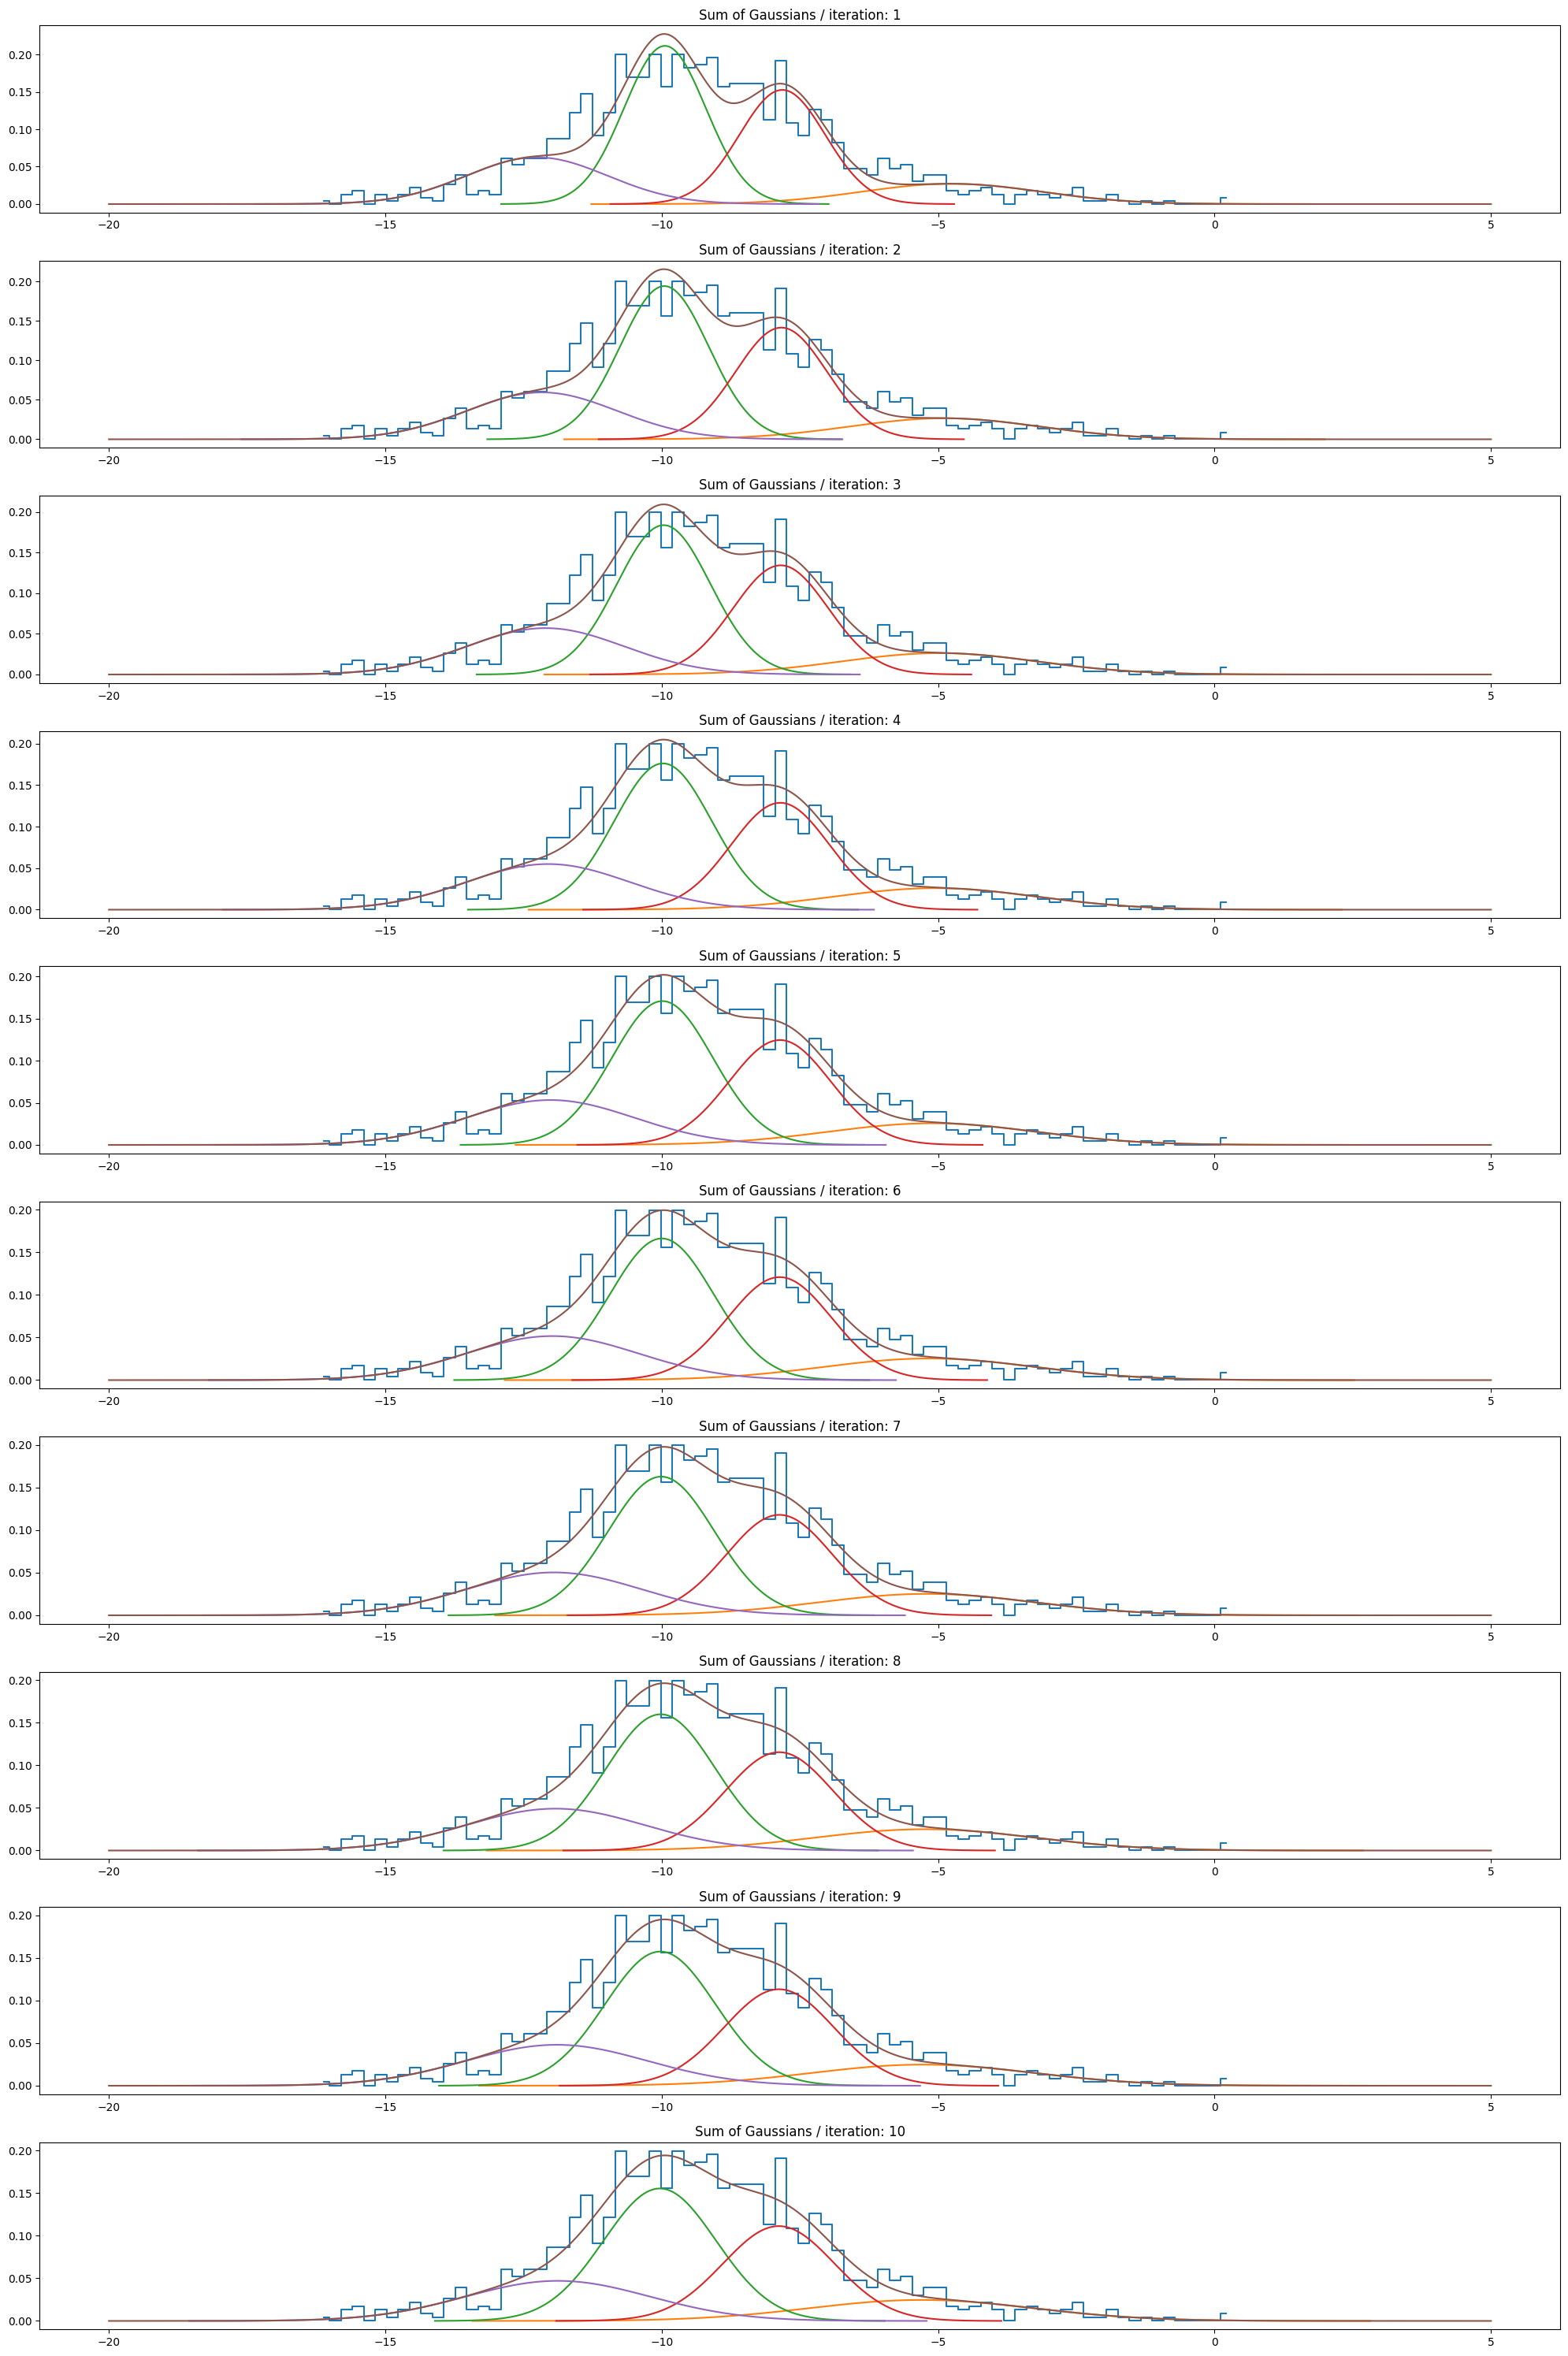

In [599]:
fig, axs = plt.subplots(number_of_iterations, 1, figsize=(20, 30))

for iteration in range(1, number_of_iterations+1):
    # for k in range(len(g_vow_init)):
        # print(mu_vow[iteration-1][k], sigma_vow[iteration-1][k], g_vow[iteration-1][k])
    mu, sigma, g = gmm_update(x_vow, mu_vow[iteration-1], sigma_vow[iteration-1], g_vow[iteration-1])
    mu_vow[iteration] = mu
    sigma_vow[iteration] = sigma
    g_vow[iteration] = g


    mu, sigma, g = gmm_update(x_cons, mu_cons[iteration-1], sigma_cons[iteration-1], g_cons[iteration-1])
    g_cons[iteration] = g
    mu_cons[iteration] = mu
    sigma_cons[iteration] = sigma

    
    probabilities = hist_vow / np.sum(hist_vow)
    probabilities = probabilities / (bin_centers_vow[1] - bin_centers_vow[0])

    axs[iteration-1].step(bin_centers_vow, probabilities, where='mid')
    plot_full_gaussian(mu_vow[iteration], sigma_vow[iteration], g_vow[iteration], ax=axs[iteration-1])
    plot_gaussian_sum(mu_vow[iteration], sigma_vow[iteration], g_vow[iteration], title=("Sum of Gaussians / iteration: " + str(iteration)), ax=axs[iteration-1])
    # plt.show()

plt.tight_layout()
plt.show()
# print("Final g_vow:", sigma_vow)
# print("Final g_cons:", sigma_cons)

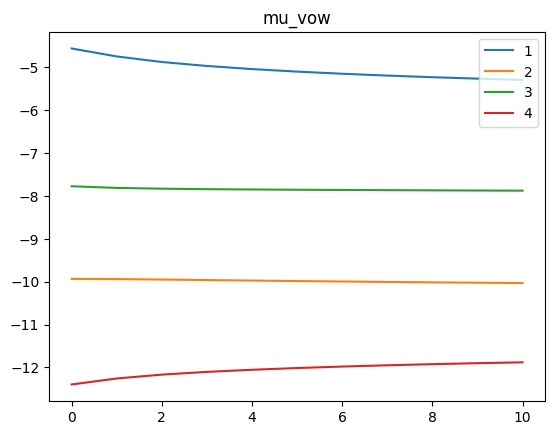

In [610]:
def plot_all_columns(data, name, ax):
    for i in range(len(data[0])):
        ax.plot(data[:, i])
        ax.legend(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

    ax.set_title(name)
    # plt.show()

plot_all_columns(mu_vow, "mu_vow", ax=plt.subplots(1, 1)[1])

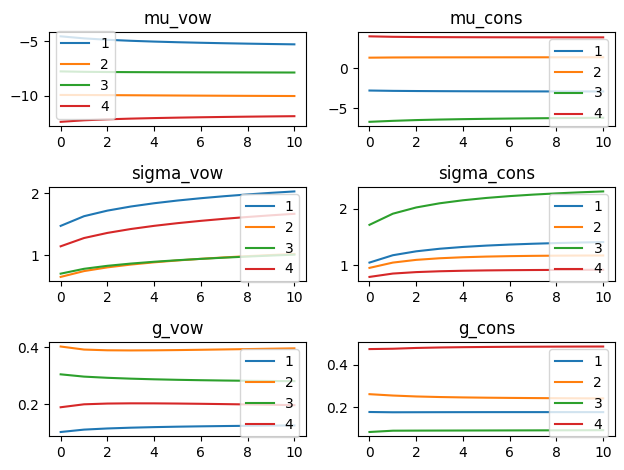

In [614]:
fig, axs = plt.subplots(3, 2)
plot_all_columns(mu_vow, 'mu_vow', axs[0, 0])
plot_all_columns(sigma_vow, 'sigma_vow', axs[1, 0])
plot_all_columns(g_vow, 'g_vow', axs[2, 0])
plot_all_columns(mu_cons, 'mu_cons', axs[0, 1])
plot_all_columns(sigma_cons, 'sigma_cons', axs[1, 1])
plot_all_columns(g_cons, 'g_cons', axs[2, 1])

plt.tight_layout()
plt.show()


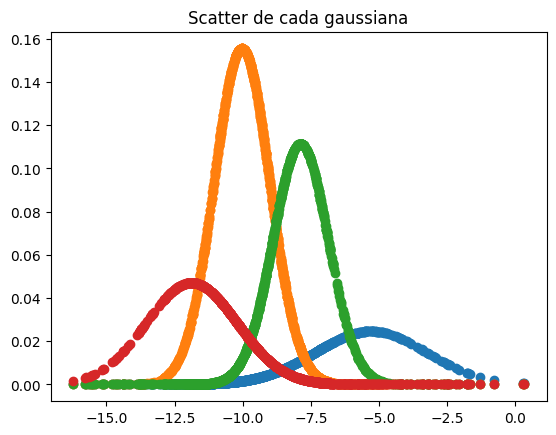

0.12545632824980882
0.3965351065965259
0.28111021630721716
0.19683607235488898


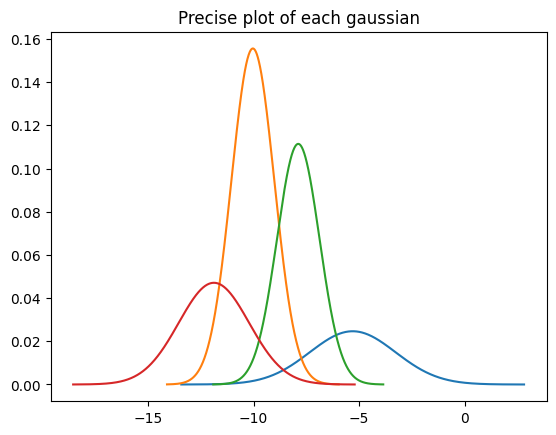

Integral do plot do gaussiano 0.9999998705043397


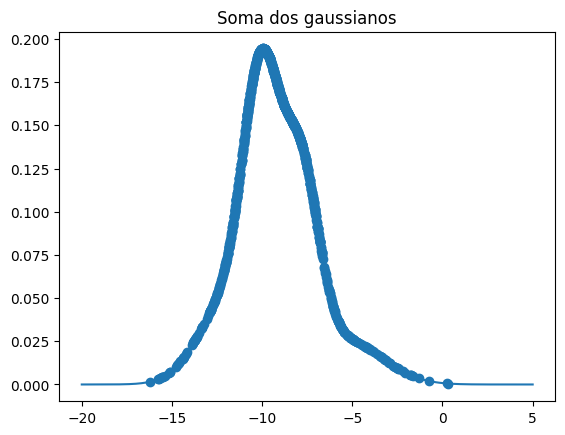

Integral do plot do gaussiano 0.9999998705043397


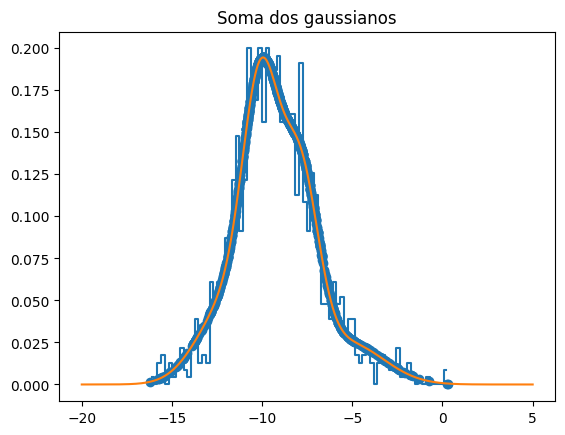

In [623]:
def plot_gaussian(x, mu, sigma, g):
    y = g * norm.pdf(x, mu, sigma)
    plt.scatter(x, y)
    plt.title("Scatter de cada gaussiana")

for k in range(4):
    plot_gaussian(x_vow, mu_vow[-1][k], sigma_vow[-1][k], g_vow[-1][k])
plt.show()

def plot_full_gaussian(mu, sigma, g):
    x = np.linspace(mu - 4*sigma, mu+4*sigma, num=1000)
    y = g * norm.pdf(x, mu, sigma)
    plt.plot(x, y)
    plt.title("Precise plot of each gaussian")
    print(np.sum(y) * (x[1] - x[0]))


for k in range(4):
    plot_full_gaussian(mu_vow[-1][k], sigma_vow[-1][k], g_vow[-1][k])
plt.show()

def scatter_gaussian_sum(x, mu, sigma, g):
    y = np.zeros(len(x))
    for i in range(len(mu)):
        y += g[i] * norm.pdf(x, mu[i], sigma[i])
    plt.scatter(x, y)
    plt.title("Scatter da soma dos gaussianos")

def plot_gaussian_sum(mu, sigma, g):
    x = np.linspace(-20, 5, num=1000)
    y = np.zeros(len(x))
    for i in range(len(mu)):
        y += g[i] * norm.pdf(x, mu[i], sigma[i])
    plt.plot(x, y)
    plt.title("Soma dos gaussianos")

    print("Integral do plot do gaussiano", np.sum(y) * (x[1] - x[0]))


probabilities = hist_vow / np.sum(hist_vow)
probabilities = probabilities / (bin_centers_vow[1] - bin_centers_vow[0])

scatter_gaussian_sum(x_vow, mu_vow[-1], sigma_vow[-1], g_vow[-1])
plot_gaussian_sum(mu=mu_vow[-1], sigma=sigma_vow[-1], g=g_vow[-1])
plt.show()

plt.step(bin_centers_vow, probabilities, where='mid')
scatter_gaussian_sum(x_vow, mu_vow[-1], sigma_vow[-1], g_vow[-1])
plot_gaussian_sum(mu=mu_vow[-1], sigma=sigma_vow[-1], g=g_vow[-1])

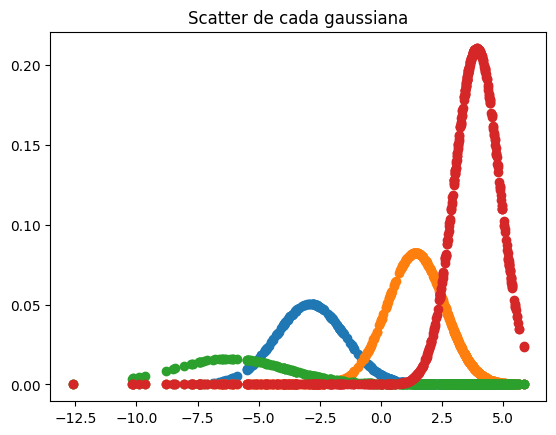

0.17825551872115133
0.24249084237356805
0.09365026526611787
0.4855410971475623


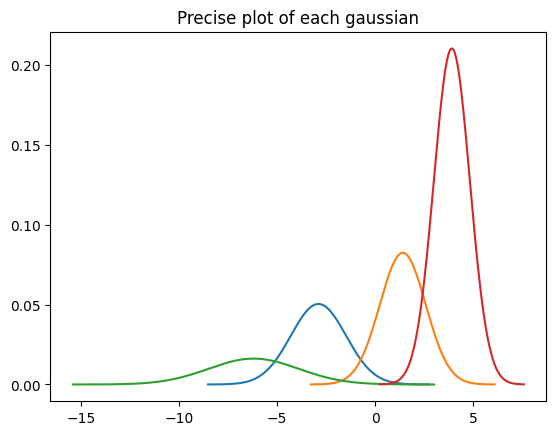

Integral do plot do gaussiano 0.9429937262178186


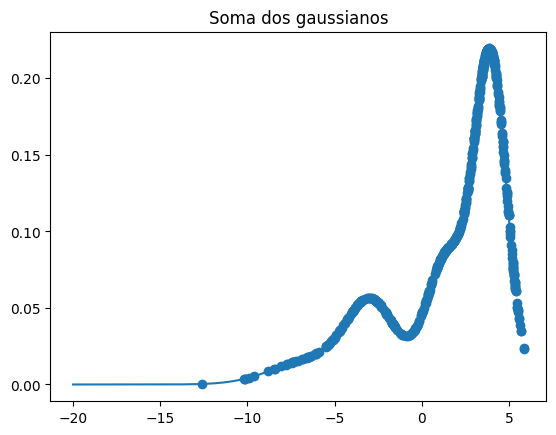

Integral do plot do gaussiano 0.9429937262178186


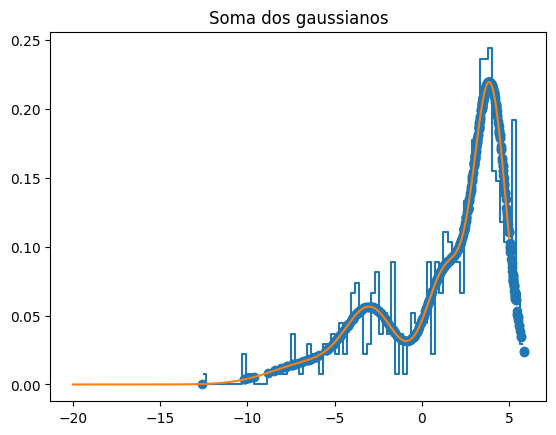

In [624]:
for k in range(4):
    plot_gaussian(x_cons, mu_cons[-1][k], sigma_cons[-1][k], g_cons[-1][k])
plt.show()

for k in range(4):
    plot_full_gaussian(mu_cons[-1][k], sigma_cons[-1][k], g_cons[-1][k])
plt.show()

scatter_gaussian_sum(x_cons, mu_cons[-1], sigma_cons[-1], g_cons[-1])
plot_gaussian_sum(mu=mu_cons[-1], sigma=sigma_cons[-1], g=g_cons[-1])
plt.show()

probabilities = hist_cons / np.sum(hist_cons)
probabilities = probabilities / (bin_centers_cons[1] - bin_centers_cons[0])
plt.step(bin_centers_cons, probabilities, where='mid')

scatter_gaussian_sum(x_cons, mu_cons[-1], sigma_cons[-1], g_cons[-1])
plot_gaussian_sum(mu=mu_cons[-1], sigma=sigma_cons[-1], g=g_cons[-1])

# Bayes Decision

In [634]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [652]:
def evaluate_hist(x):
    prob_vow = pdf_hist(x, hist_vow, bin_centers_vow)
    prob_cons = pdf_hist(x, hist_cons, bin_centers_cons)
    return prob_vow > prob_cons

def evaluate_gmm(x):
    prob_vow = np.sum(pdf_gmm(x, mu_vow[-1], sigma_vow[-1], g_vow[-1]))
    prob_cons = np.sum(pdf_gmm(x, mu_cons[-1], sigma_cons[-1], g_cons[-1]))
    # print(prob_vow, prob_cons)
    return prob_vow > prob_cons

print(evaluate_hist(0.5))
print(evaluate_gmm(0.5))

False
False


[[ 620   22]
 [  77 1031]]
True
[[ 624   18]
 [  99 1009]]


<Axes: >

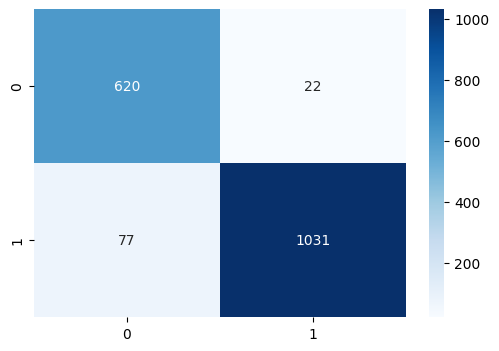

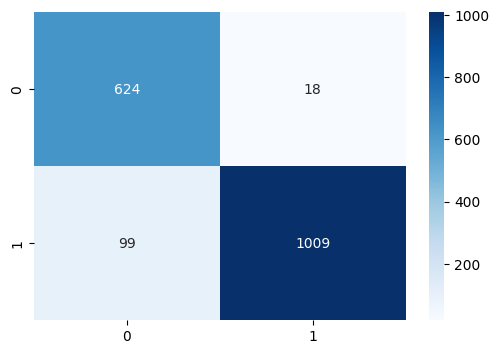

In [653]:
mat = scipy.io.loadmat('files_tut4/feat_eval_vow.mat')
x_vow_eval = mat['x_vow_eval'][0]

mat = scipy.io.loadmat('files_tut4/feat_eval_cons.mat')
x_cons_eval = mat['x_cons_eval'][0]

x_eval = np.concatenate((x_vow_eval, x_cons_eval))

y_true = np.zeros(len(x_vow_eval) + len(x_cons_eval))
y_true[:len(x_vow_eval)] = 1

y_pred_hist = np.zeros(len(x_vow_eval) + len(x_cons_eval))
y_pred_hist = np.array([evaluate_hist(x) for x in x_eval])

cm = confusion_matrix(y_true, y_pred_hist)
print(cm)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

y_pred_gmm = np.zeros(len(x_vow_eval) + len(x_cons_eval))
print(evaluate_gmm(x_eval[0]))
y_pred_gmm = np.array([evaluate_gmm(x) for x in x_eval])

cm = confusion_matrix(y_true, y_pred_gmm)
print(cm)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')


Integral do plot do gaussiano 0.9999998705043397
Integral do plot do gaussiano 0.9429937262178186


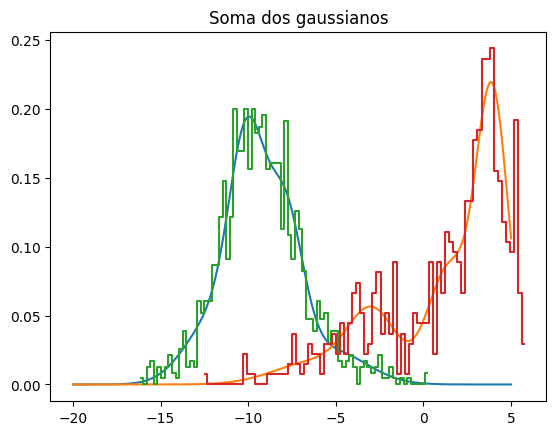

In [668]:
plot_gaussian_sum(mu=mu_vow[-1], sigma=sigma_vow[-1], g=g_vow[-1])
plot_gaussian_sum(mu=mu_cons[-1], sigma=sigma_cons[-1], g=g_cons[-1])

probabilities = hist_vow / np.sum(hist_vow)
probabilities = probabilities / (bin_centers_vow[1] - bin_centers_vow[0])

plt.step(bin_centers_vow, probabilities, where='mid')

probabilities = hist_cons / np.sum(hist_cons)
probabilities = probabilities / (bin_centers_cons[1] - bin_centers_cons[0])

plt.step(bin_centers_cons, probabilities, where='mid')

In [658]:
def evaluate_custom_gmm(x, mu_vow, sigma_vow, g_vow, mu_cons, sigma_cons, g_cons):
    prob_vow = np.sum(norm.pdf(x, mu_vow, sigma_vow) * g_vow)
    prob_cons = np.sum(norm.pdf(x, mu_cons, sigma_cons) * g_cons)
    
    return prob_vow > prob_cons


mu_vow_sklearn: [-10.06059196  -5.2636206  -11.93968894  -7.91266548]
sigma_vow_sklearn: [0.99564533 2.00469394 1.63754709 1.00713168]
g_vow_sklearn: [0.39131361 0.12409743 0.19244779 0.29214117]
mu_cons_sklearn: [ 3.91437451 -2.95997888  1.35638266 -6.60596573]
sigma_cons_sklearn: [0.91657954 1.37412882 1.14809648 2.10879624]
g_cons_sklearn: [0.48991579 0.18687774 0.24086907 0.08233739]
[[ 624   18]
 [  91 1017]]


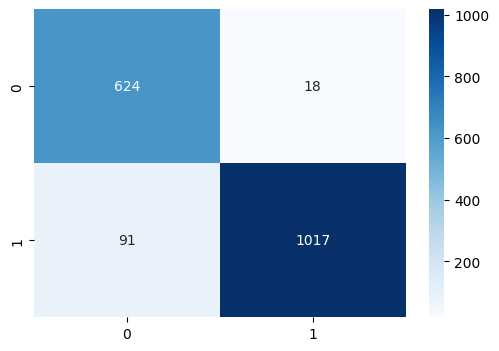

Integral do plot do gaussiano 0.9432718886134942


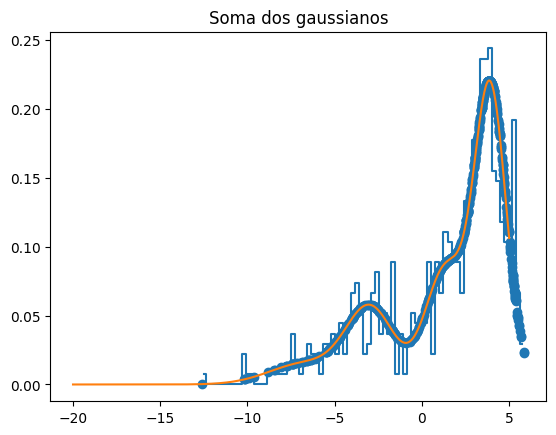

Integral do plot do gaussiano 0.9432718886134942
Integral do plot do gaussiano 0.9429937262178186


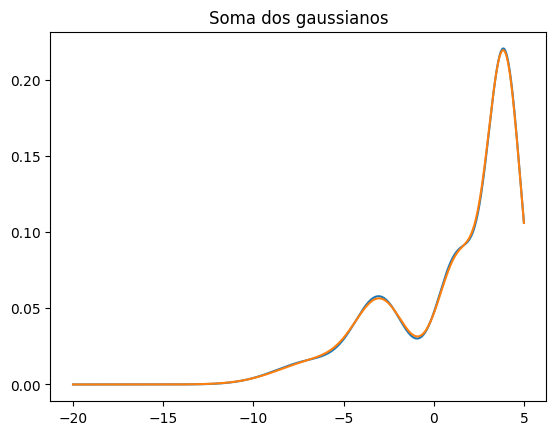

0.4898852835471654
0.17825551872115133
0.1868661067655907
0.24249084237356805
0.24085407161574446
0.09365026526611787
0.08233226157991694
0.4855410971475623


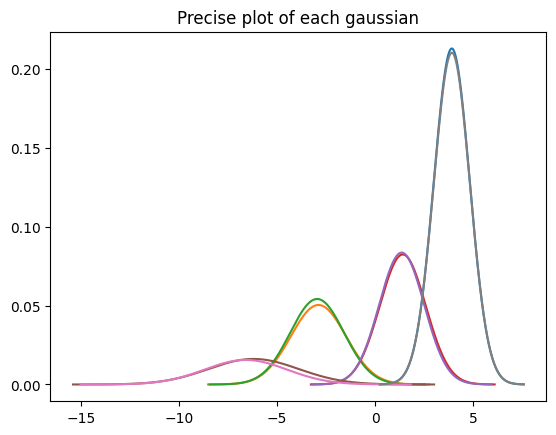

In [666]:
# Exemplo de uso:
# mu_vow, sigma_vow, g_vow = gmm_classifier(x_vow, mu_vow_init, sigma_vow_init, g_vow_init, number_of_iterations)
# mu_cons, sigma_cons, g_cons = gmm_classifier(x_cons, mu_cons_init, sigma_cons_init, g_cons_init, number_of_iterations)
from sklearn.mixture import GaussianMixture

def gmm_classifier_sklearn(train_data, num_components, num_iterations):
    gmm = GaussianMixture(n_components=num_components, max_iter=num_iterations)
    gmm.fit(train_data.reshape(-1, 1))
    return gmm.means_.flatten(), np.sqrt(gmm.covariances_).flatten(), gmm.weights_

# Exemplo de uso:
mu_vow_sklearn, sigma_vow_sklearn, g_vow_sklearn = gmm_classifier_sklearn(x_vow, 4, number_of_iterations)
mu_cons_sklearn, sigma_cons_sklearn, g_cons_sklearn = gmm_classifier_sklearn(x_cons, 4, number_of_iterations)

print("mu_vow_sklearn:", mu_vow_sklearn)
print("sigma_vow_sklearn:", sigma_vow_sklearn)
print("g_vow_sklearn:", g_vow_sklearn)

print("mu_cons_sklearn:", mu_cons_sklearn)
print("sigma_cons_sklearn:", sigma_cons_sklearn)
print("g_cons_sklearn:", g_cons_sklearn)

y_pred_gmm_sklearn = np.zeros(len(x_vow_eval) + len(x_cons_eval))
y_pred_gmm_sklearn = np.array([evaluate_custom_gmm(x, mu_vow_sklearn, sigma_vow_sklearn, g_vow_sklearn, mu_cons_sklearn, sigma_cons_sklearn, g_cons_sklearn) for x in x_eval])

cm = confusion_matrix(y_true, y_pred_gmm_sklearn)
print(cm)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

probabilities = hist_cons / np.sum(hist_cons)
probabilities = probabilities / (bin_centers_cons[1] - bin_centers_cons[0])
plt.step(bin_centers_cons, probabilities, where='mid')

scatter_gaussian_sum(x_cons, mu_cons_sklearn, sigma_cons_sklearn, g_cons_sklearn)
plot_gaussian_sum(mu=mu_cons_sklearn, sigma=sigma_cons_sklearn, g=g_cons_sklearn)
plt.show()

plot_gaussian_sum(mu=mu_cons_sklearn, sigma=sigma_cons_sklearn, g=g_cons_sklearn)
plot_gaussian_sum(mu=mu_cons[-1], sigma=sigma_cons[-1], g=g_cons[-1])
plt.show()

for k in range(4):
    plot_full_gaussian(mu_cons_sklearn[k], sigma_cons_sklearn[k], g_cons_sklearn[k])
    plot_full_gaussian(mu_cons[-1][k], sigma_cons[-1][k], g_cons[-1][k])
